In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [50]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# File paths for signal and background root files
signal_file_path = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/photons_0PU_bc_stc_hadd.root"
bg_file_path = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/PU200_neutrino.h5"

# Open the root files (without 'with' to keep files open)
signal_file = uproot.open(signal_file_path)

# Open the HDF5 file for background (using pandas)
bg_file = pd.read_hdf(bg_file_path)  # Background data (already filtered)

# Folder names where the trees are stored (for ROOT file)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
bg_folder = "l1tHGCalTriggerNtuplizer"  # This won't be used since we already have the background data in the form of a DataFrame

# Tree name to access within each file
tree_name = "HGCalTriggerNtuple"

# Build paths to the trees for ROOT file
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [4]:
# Function to load and filter the signal tree data (for ROOT file)
def load_and_filter_signal_tree(tree, filter_pt, eta_range=(1.6, 2.8), cl_pt_threshold=5):
    df = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["gen_n", "gen_eta", "gen_phi", "gen_pt", 
                     "genpart_exeta", "genpart_exphi", "*cl3d*", "event"]
    ))
    df_filtered = df[(df['gen_pt'] > filter_pt) & 
                     (df['gen_eta'] > eta_range[0]) & 
                     (df['gen_eta'] < eta_range[1]) &
                     (df['cl3d_eta'] > eta_range[0]) & 
                     (df['cl3d_eta'] < eta_range[1]) &
                     (df['cl3d_pt'] > cl_pt_threshold)]
    return df_filtered

In [5]:
# Apply the filter to the signal data (only signal data needs filtering)
signal_df_filtered = load_and_filter_signal_tree(signal_tree, filter_pt=20)

# Since the background data is already filtered, no additional filtering is needed for it.
bg_df_filtered = bg_file  # Assuming the background DataFrame is already filtered

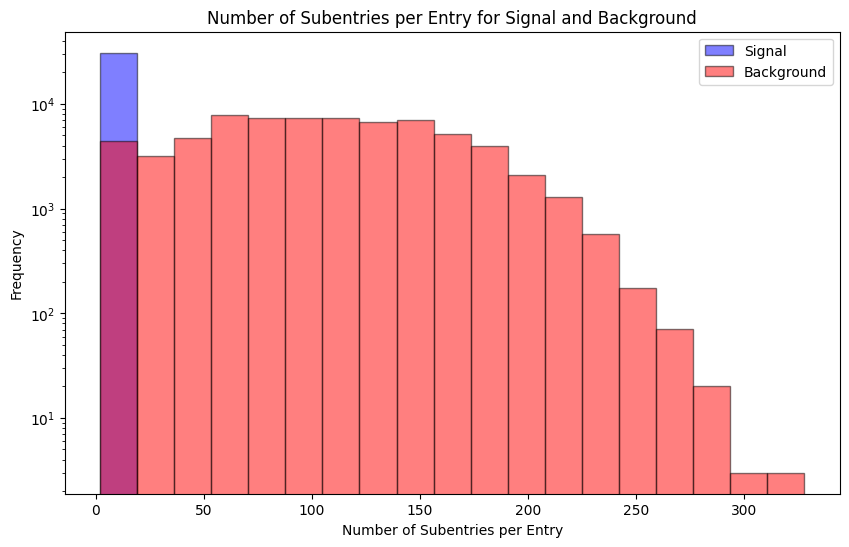

In [9]:
def count_subentries(df, entry_column="event", subentry_column="gen_n"):
    # Count the number of subentries (e.g., gen_n) for each entry (e.g., event)
    subentry_counts = df.groupby(entry_column)[subentry_column].count()
    return subentry_counts

# Count subentries for signal and background
signal_subentries = count_subentries(signal_df_filtered)
bg_subentries = count_subentries(bg_df_filtered)

# Create histograms for signal and background
plt.figure(figsize=(10, 6))

num_bins = 20
bins = np.linspace(min(min(signal_subentries), min(bg_subentries)), 
                  max(max(signal_subentries), max(bg_subentries)), 
                  num_bins)
# Plot the histograms
plt.hist(signal_subentries, bins=bins, alpha=0.5, label="Signal", color="blue", edgecolor="black")
plt.hist(bg_subentries, bins=bins, alpha=0.5, label="Background", color="red", edgecolor="black")

# Labels and title
plt.xlabel('Number of Subentries per Entry')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Number of Subentries per Entry for Signal and Background')
plt.legend()

# Show the plot
plt.show()

In [27]:
bg_df_filtered = bg_df_filtered[bg_df_filtered['cl3d_pt'] > 20]
bg_df_filtered = bg_df_filtered[bg_df_filtered['cl3d_eta'] > 1.6]

In [28]:
bg_df_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_eot,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy
766,7,1615,39.425083,-1.249046,2.808667e-15,2.804403,-2.937500,186,3020694528,21.200855,...,0.830414,8191,3584,2850944,32.210129,62.641769,-0.998929,0,0.000000,0.000000
767,7,1615,39.425083,-1.249046,2.808667e-15,2.804403,-2.937500,186,3020694528,21.200855,...,0.830414,8191,3584,2850944,32.210129,62.641769,-0.998929,0,10.835677,66.480591
2908,32,609,0.544641,-1.526120,8.741343e-01,0.155098,3.531542,187,3021218560,20.241825,...,0.344525,8159,3072,3637256,8.795520,38.852940,-0.998968,0,0.000000,0.000000
2909,32,609,0.544641,-1.526120,8.741343e-01,0.155098,3.531542,187,3021218560,20.241825,...,0.344525,8159,3072,3637256,8.795520,38.852940,-0.998968,0,4.848836,38.550568
2954,32,609,-1.511871,2.418126,1.446784e+00,2.546933,-4.863599,187,3020178708,23.436556,...,0.064233,3880,0,1048576,0.715991,0.961778,-0.998945,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346329,157282,2636,2.158431,2.676478,3.080648e+00,-1.278087,0.549843,242,2991891216,21.109205,...,0.436408,8190,384,2080768,21.442961,46.415447,-0.996330,0,6.884161,34.541248
7350391,157356,2500,-40.345062,0.013020,3.330952e-16,2.697141,2.771971,237,3020313938,20.063242,...,0.060146,8150,0,1179648,0.720970,0.968468,-0.998945,0,0.000000,0.000000
7350392,157356,2500,-40.345062,0.013020,3.330952e-16,2.697141,2.771971,237,3020313938,20.063242,...,0.060146,8150,0,1179648,0.720970,0.968468,-0.998945,0,30.588881,146.309738
7350411,157356,2500,22765.871094,0.000000,0.000000e+00,3.090309,-2.504484,237,3037004290,24.168907,...,0.014261,2848,0,1572864,2.490771,4.399914,-0.998505,0,0.000000,0.000000


In [14]:
signal_df_filtered

event  gen_n   gen_eta   gen_phi     gen_pt   
entry  subentry subsubentry                                                 
14     1        0              4680      2  1.917820 -1.477744  94.053398  \
                1              4680      2  1.917820 -1.477744  94.053398   
32     1        0              4673      2  2.384520  2.920790  92.494370   
                1              4673      2  2.384520  2.920790  92.494370   
37     1        0              4704      2  2.319600 -0.470938  40.315086   
...                             ...    ...       ...       ...        ...   
199996 1        1            113021      2  2.371188 -0.263157  83.995270   
199997 1        0            113033      2  2.563171 -2.477782  79.166039   
                1            113033      2  2.563171 -2.477782  79.166039   
199999 1        0            113034      2  2.788458 -0.375976  94.751396   
                1            113034      2  2.788458 -0.375976  94.751396   

                             genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry  subentry subsubentry                                                     
14     1        0                -1.477757       1.916971       2  2996761669  \
                1                -1.477757       1.916971       2  2996761669   
32     1        0                 2.920803       2.378510       2  2989237283   
                1                 2.920803       2.378510       2  2989237283   
37     1        0                -0.470946       2.337719       2  2989905154   
...                                    ...            ...     ...         ...   
199996 1        1                -0.263162       2.357926       2  2988848195   
199997 1        0                -2.477798       2.571761       2  2988851457   
                1                -2.477798       2.571761       2  2988851457   
199999 1        0                -0.376017       2.783430       2  2989372195   
                1                -0.376017       2.783430       2  2989372195   

                               cl3d_pt  ...  cl3d_eot  cl3d_ebm0  cl3d_ebm1   
entry  subentry subsubentry             ...                                   
14     1        0            86.336327  ...  0.998368      16383       8184  \
                1            86.336327  ...  0.998368      16383       8184   
32     1        0            85.325951  ...  1.000000      16383       4088   
                1            85.325951  ...  1.000000      16383       4088   
37     1        0            34.215042  ...  1.000000      16383       2032   
...                                ...  ...       ...        ...        ...   
199996 1        1            76.130898  ...  0.993184      16383       4092   
199997 1        0            73.411713  ...  1.000000      16383       8176   
                1            73.411713  ...  1.000000      16383       8176   
199999 1        0            87.961372  ...  0.998474      16383       4092   
                1            87.961372  ...  0.998474      16383       4092   

                             cl3d_hbm  cl3d_ntc67  cl3d_ntc90  cl3d_bdteg   
entry  subentry subsubentry                                                 
14     1        0             8388607    8.594174   28.036911    0.998573  \
                1             8388607    8.594174   28.036911    0.998573   
32     1        0             8388607    9.826604   27.081308    0.998573   
                1             8388607    9.826604   27.081308    0.998573   
37     1        0             8388607    8.204144   25.379555    0.986959   
...                               ...         ...         ...         ...   
199996 1        1             8388607   11.520021   26.761082    0.998573   
199997 1        0             8388607    8.931447   34.923149    0.998573   
                1             8388607    8.931447   34.923149    0.998573   
199999 1        0             8388607    9.559611   27.556578    0.998067   
                1     

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(df_signal, df_bg, variables, num_bins=40, int_num_bins=20, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    # Filter the signal and background DataFrames for cl3d_pt within the specified range
    df_signal_filtered = df_signal[(df_signal['cl3d_pt'] >= cl3d_pt_range[0]) & (df_signal['cl3d_pt'] <= cl3d_pt_range[1])]
    df_bg_filtered = df_bg[(df_bg['cl3d_pt'] >= cl3d_pt_range[0]) & (df_bg['cl3d_pt'] <= cl3d_pt_range[1])]

    for var in variables:
        plt.figure(figsize=figsize)
        
        # Check if the column contains integer values
        if df_signal_filtered[var].dtype in ['int64', 'int32']:
            # For integer columns, set the bin size to 1 and center the bins around integer values
            min_value = min(df_signal_filtered[var].min(), df_bg_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg_filtered[var].max())
            
            # Create bin edges with a size of 1, centered around integers
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
            
        else:
            # For non-integer columns, use a normal binning strategy
            min_value = min(df_signal_filtered[var].min(), df_bg_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg_filtered[var].max())
            bin_width = (max_value - min_value) / num_bins
            
            # Adjust bin edges to center the bins around the data values
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)

        # Plot the signal and background histograms with normalized distributions
        plt.hist(df_signal_filtered[var], bins=bin_edges, color='b', alpha=0.5, label='Signal', edgecolor='black', density=True)
        plt.hist(df_bg_filtered[var], bins=bin_edges, color='r', alpha=0.5, label='Background', edgecolor='black', density=True)
        
        # Set the plot title, labels, and log scale for y-axis
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()
        
        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Save the plot as a PNG file
        filename = f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        
        # Show the plot
        plt.show()
        
        # Close the plot to free memory
        plt.close()

In [30]:
# Define delta_r calculation function
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)


In [31]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    # Calculate delta R
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    return df_filtered

In [32]:
df_signal_final_filtered = filter_by_delta_r(signal_df_filtered, delta_r_threshold=0.05)

In [33]:
df_signal_final_filtered

event  gen_n   gen_eta   gen_phi     gen_pt   
entry  subentry subsubentry                                                 
14     1        0              4680      2  1.917820 -1.477744  94.053398  \
                1              4680      2  1.917820 -1.477744  94.053398   
32     1        0              4673      2  2.384520  2.920790  92.494370   
                1              4673      2  2.384520  2.920790  92.494370   
37     1        0              4704      2  2.319600 -0.470938  40.315086   
...                             ...    ...       ...       ...        ...   
199996 1        1            113021      2  2.371188 -0.263157  83.995270   
199997 1        0            113033      2  2.563171 -2.477782  79.166039   
                1            113033      2  2.563171 -2.477782  79.166039   
199999 1        0            113034      2  2.788458 -0.375976  94.751396   
                1            113034      2  2.788458 -0.375976  94.751396   

                             genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry  subentry subsubentry                                                     
14     1        0                -1.477757       1.916971       2  2996761669  \
                1                -1.477757       1.916971       2  2996761669   
32     1        0                 2.920803       2.378510       2  2989237283   
                1                 2.920803       2.378510       2  2989237283   
37     1        0                -0.470946       2.337719       2  2989905154   
...                                    ...            ...     ...         ...   
199996 1        1                -0.263162       2.357926       2  2988848195   
199997 1        0                -2.477798       2.571761       2  2988851457   
                1                -2.477798       2.571761       2  2988851457   
199999 1        0                -0.376017       2.783430       2  2989372195   
                1                -0.376017       2.783430       2  2989372195   

                               cl3d_pt  ...  cl3d_ebm0  cl3d_ebm1  cl3d_hbm   
entry  subentry subsubentry             ...                                   
14     1        0            86.336327  ...      16383       8184   8388607  \
                1            86.336327  ...      16383       8184   8388607   
32     1        0            85.325951  ...      16383       4088   8388607   
                1            85.325951  ...      16383       4088   8388607   
37     1        0            34.215042  ...      16383       2032   8388607   
...                                ...  ...        ...        ...       ...   
199996 1        1            76.130898  ...      16383       4092   8388607   
199997 1        0            73.411713  ...      16383       8176   8388607   
                1            73.411713  ...      16383       8176   8388607   
199999 1        0            87.961372  ...      16383       4092   8388607   
                1            87.961372  ...      16383       4092   8388607   

                             cl3d_ntc67  cl3d_ntc90  cl3d_bdteg  cl3d_quality   
entry  subentry subsubentry                                                     
14     1        0              8.594174   28.036911    0.998573             1  \
                1              8.594174   28.036911    0.998573             1   
32     1        0              9.826604   27.081308    0.998573             1   
                1              9.826604   27.081308    0.998573             1   
37     1        0              8.204144   25.379555    0.986959             1   
...                                 ...         ...         ...           ...   
199996 1        1             11.520021   26.761082    0.998573             1   
199997 1        0              8.931447   34.923149    0.998573             1   
                1              8.931447   34.923149    0.998573             1   
199999 1        0              9.559611   27.556578    

In [34]:
variables_to_plot = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
       'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr',
       'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers']

Saved: cl3d_pt_histogram_log_cl3d_pt_20_30.png


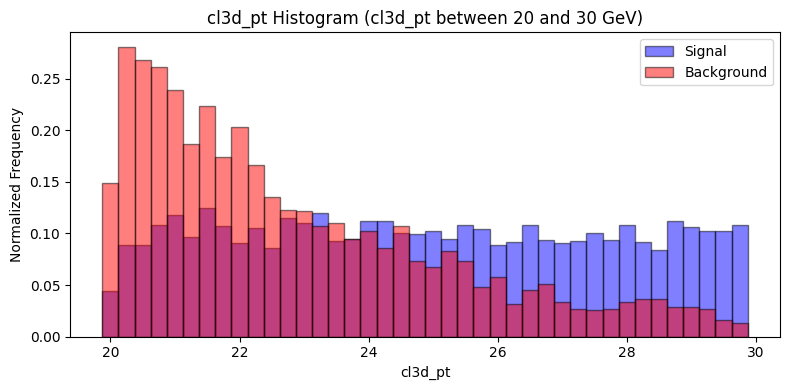

Saved: cl3d_energy_histogram_log_cl3d_pt_20_30.png


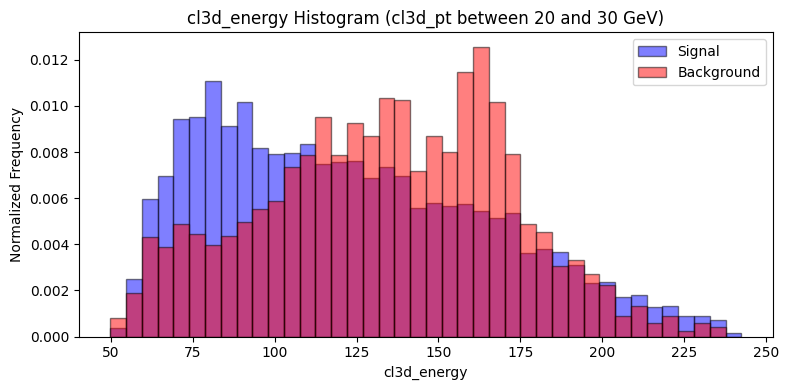

Saved: cl3d_eta_histogram_log_cl3d_pt_20_30.png


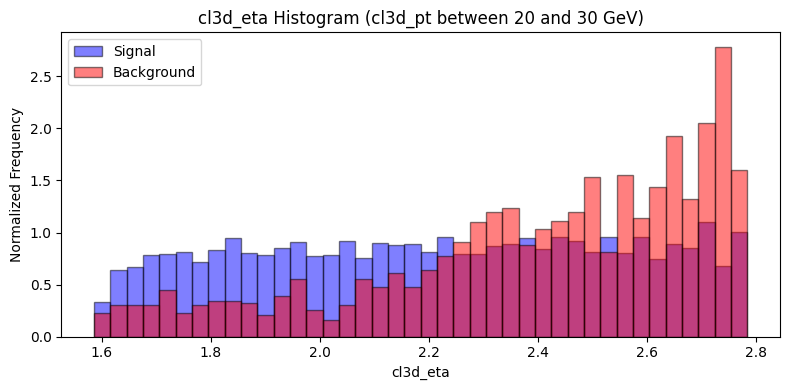

Saved: cl3d_phi_histogram_log_cl3d_pt_20_30.png


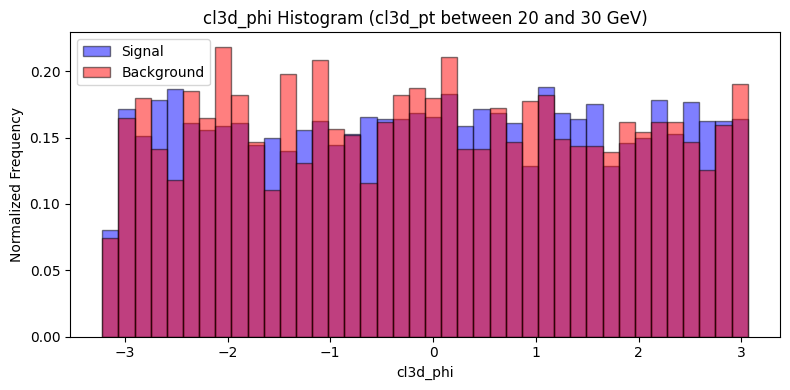

Saved: cl3d_showerlength_histogram_log_cl3d_pt_20_30.png


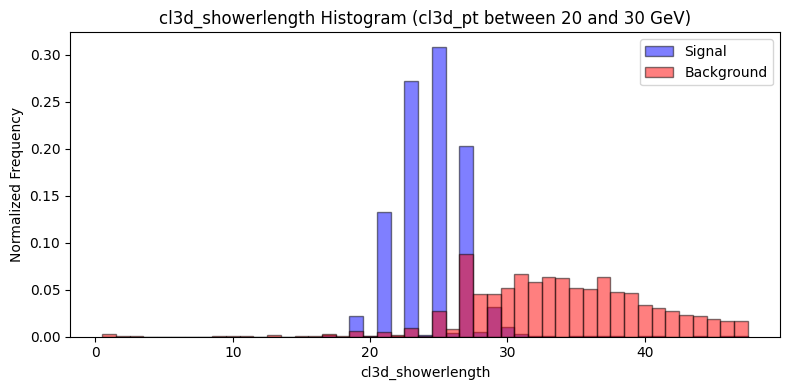

Saved: cl3d_coreshowerlength_histogram_log_cl3d_pt_20_30.png


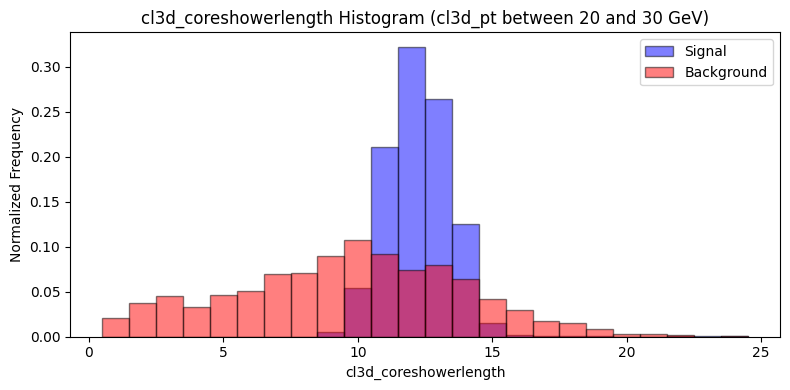

Saved: cl3d_firstlayer_histogram_log_cl3d_pt_20_30.png


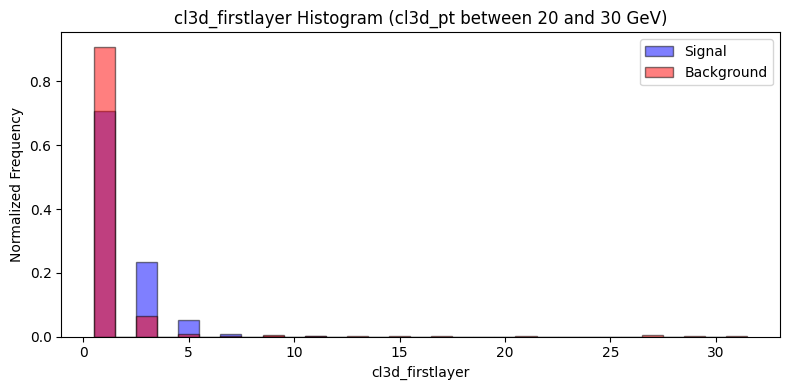

Saved: cl3d_maxlayer_histogram_log_cl3d_pt_20_30.png


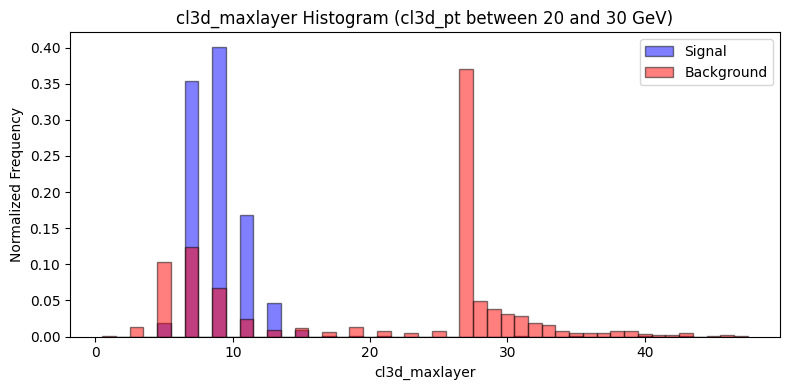

Saved: cl3d_seetot_histogram_log_cl3d_pt_20_30.png


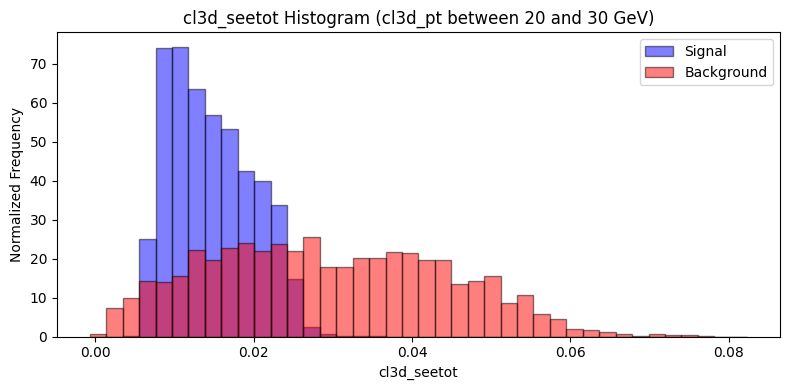

Saved: cl3d_seemax_histogram_log_cl3d_pt_20_30.png


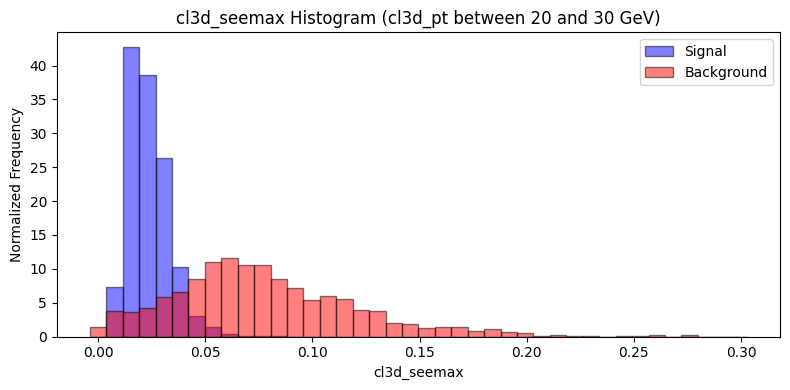

Saved: cl3d_spptot_histogram_log_cl3d_pt_20_30.png


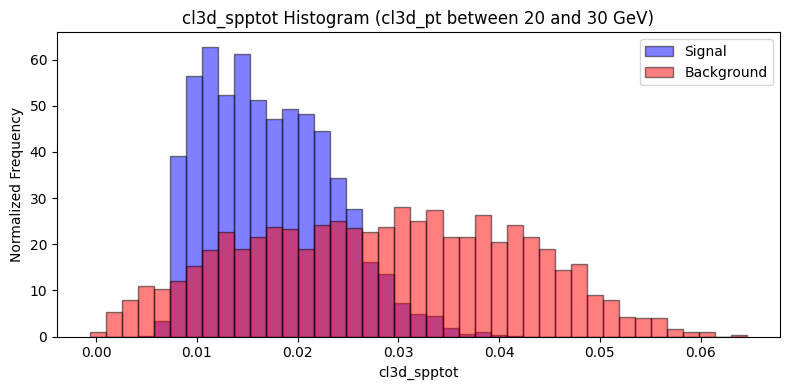

Saved: cl3d_sppmax_histogram_log_cl3d_pt_20_30.png


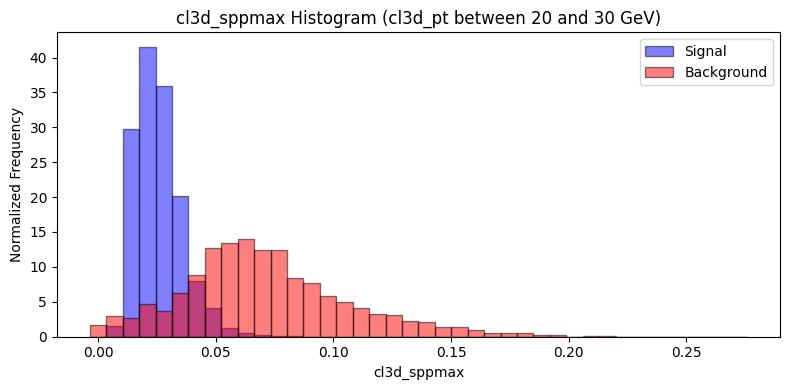

Saved: cl3d_szz_histogram_log_cl3d_pt_20_30.png


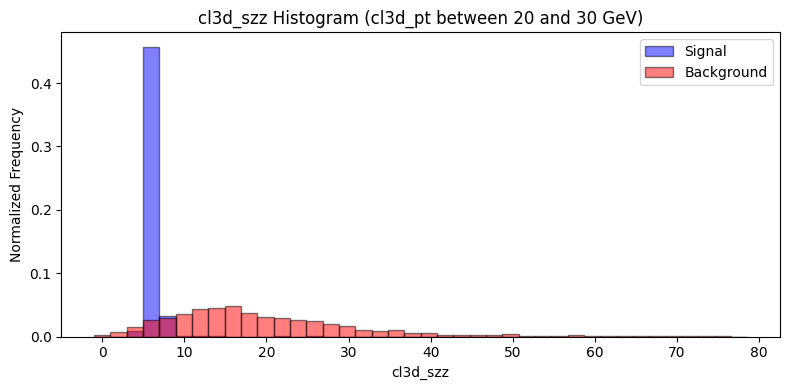

Saved: cl3d_srrtot_histogram_log_cl3d_pt_20_30.png


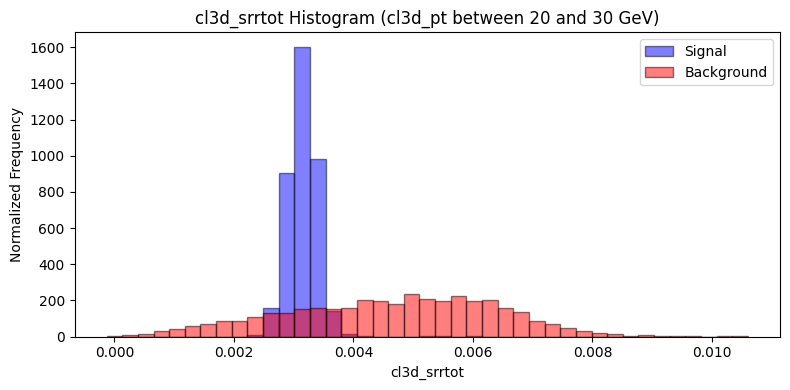

Saved: cl3d_srrmax_histogram_log_cl3d_pt_20_30.png


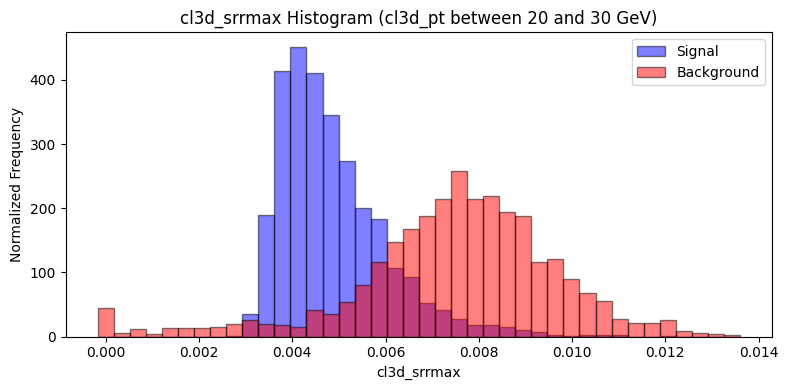

Saved: cl3d_srrmean_histogram_log_cl3d_pt_20_30.png


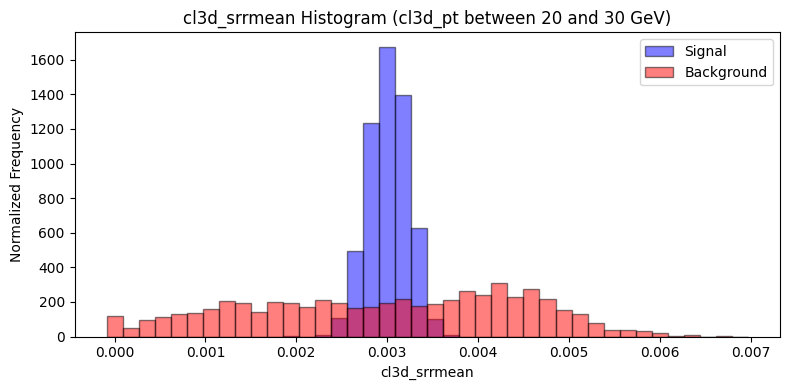

Saved: cl3d_varrr_histogram_log_cl3d_pt_20_30.png


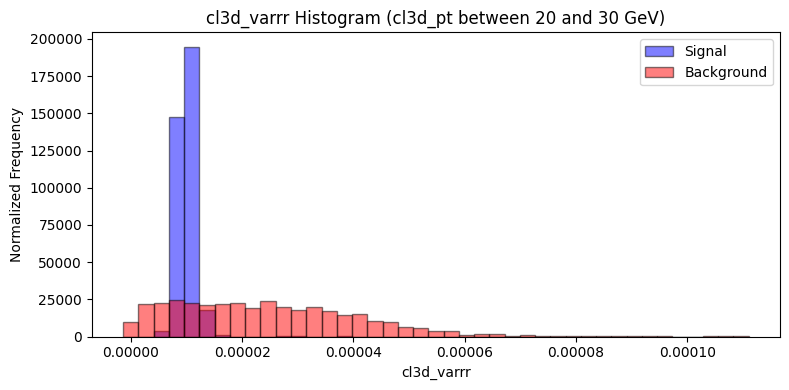

Saved: cl3d_varzz_histogram_log_cl3d_pt_20_30.png


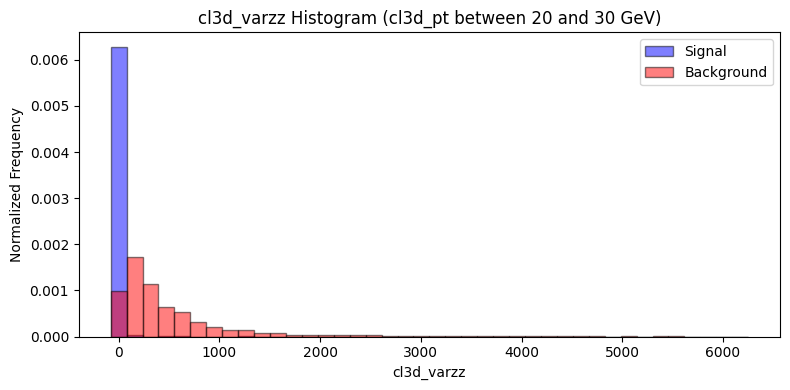

Saved: cl3d_varee_histogram_log_cl3d_pt_20_30.png


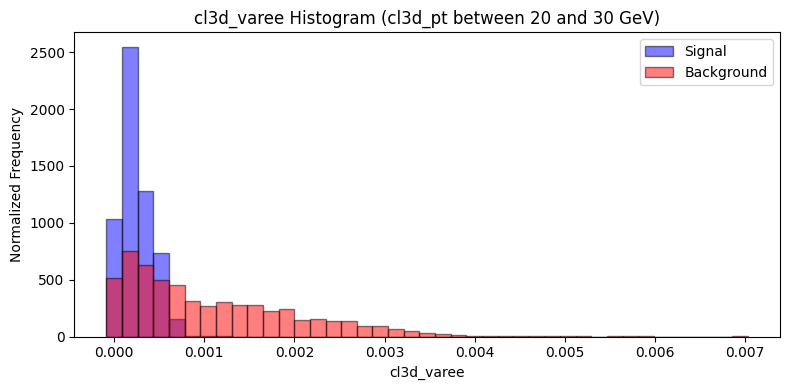

Saved: cl3d_varpp_histogram_log_cl3d_pt_20_30.png


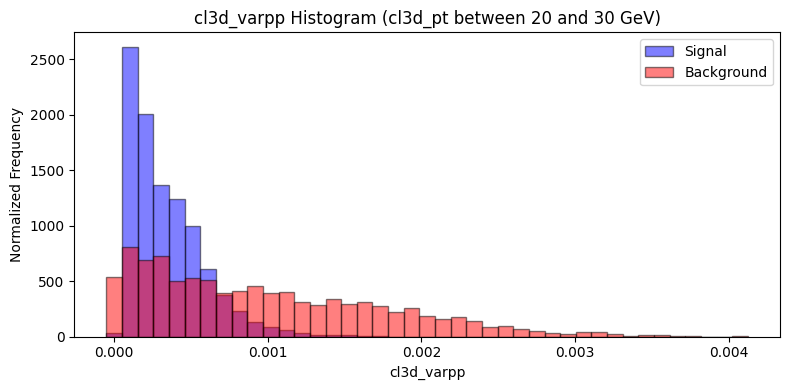

Saved: cl3d_emaxe_histogram_log_cl3d_pt_20_30.png


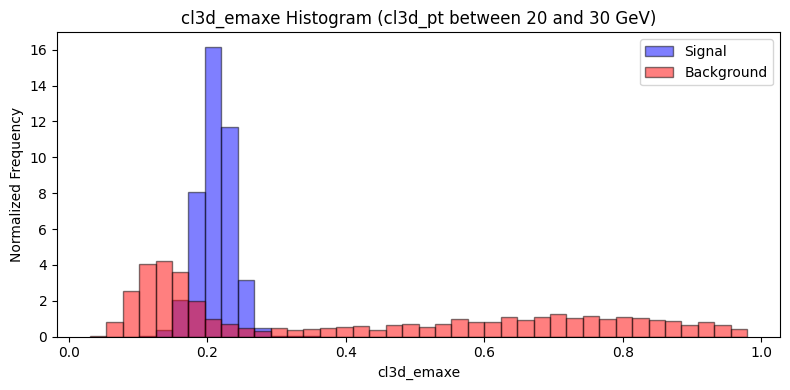

Saved: cl3d_hoe_histogram_log_cl3d_pt_20_30.png


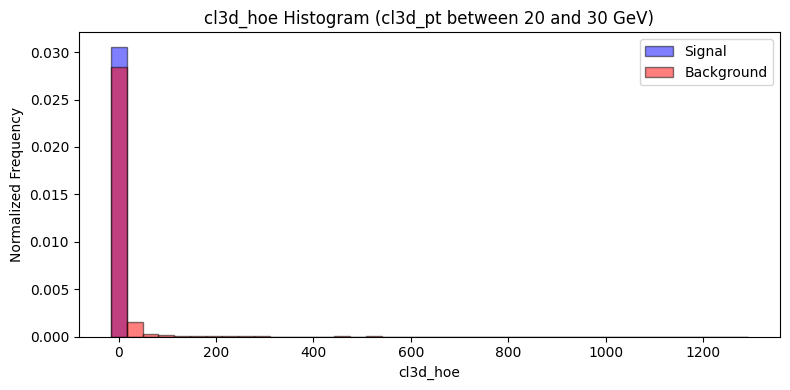

Saved: cl3d_meanz_histogram_log_cl3d_pt_20_30.png


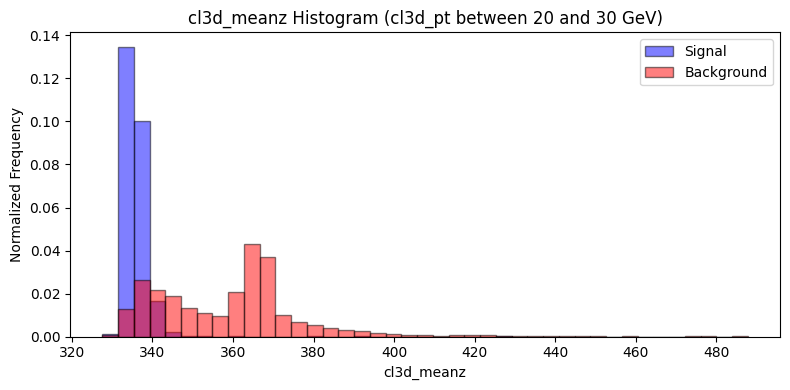

Saved: cl3d_layer10_histogram_log_cl3d_pt_20_30.png


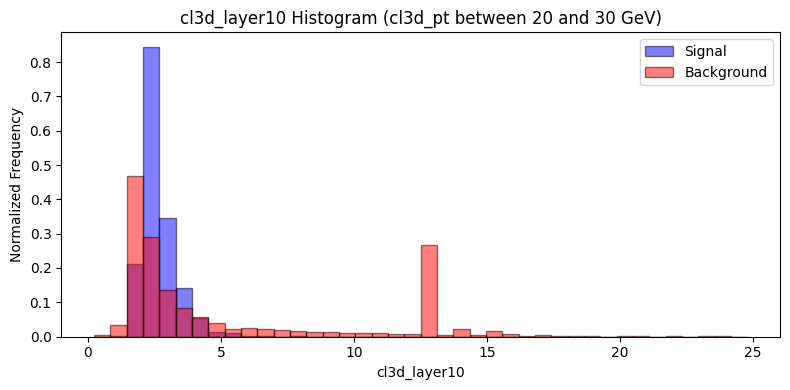

Saved: cl3d_layer50_histogram_log_cl3d_pt_20_30.png


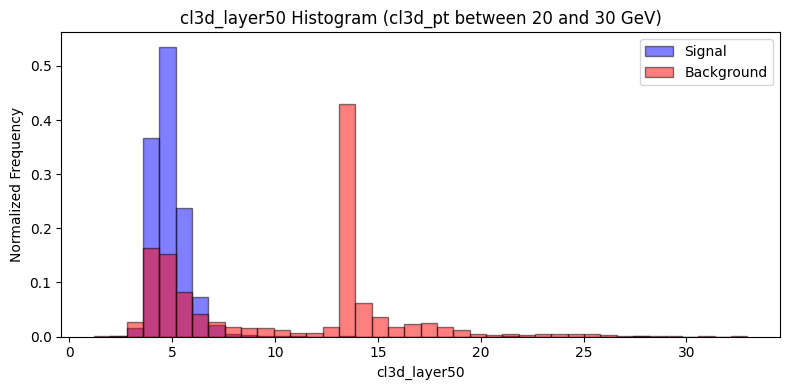

Saved: cl3d_layer90_histogram_log_cl3d_pt_20_30.png


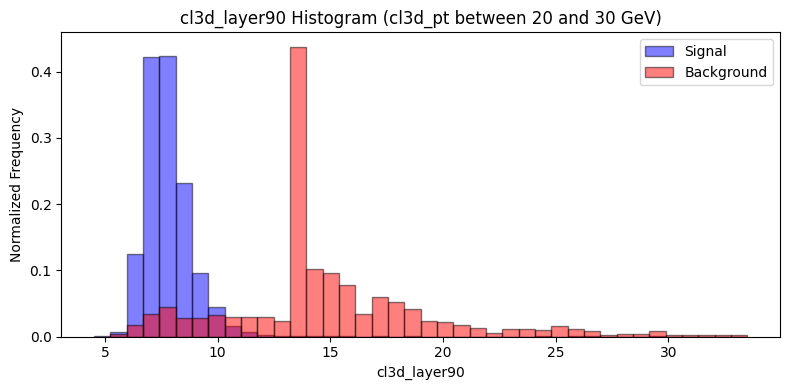

Saved: cl3d_first1layers_histogram_log_cl3d_pt_20_30.png


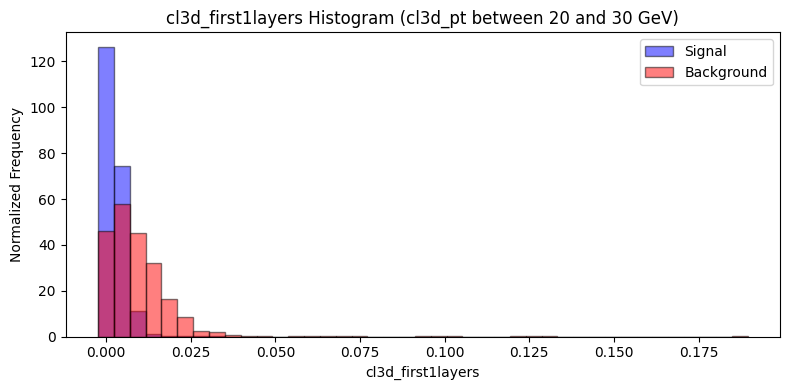

Saved: cl3d_first3layers_histogram_log_cl3d_pt_20_30.png


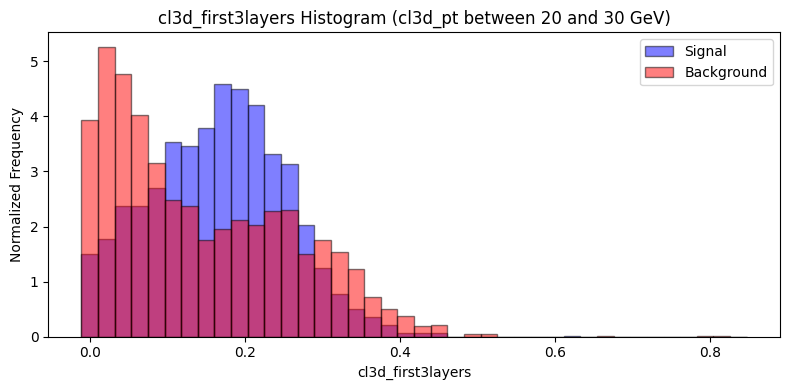

Saved: cl3d_first5layers_histogram_log_cl3d_pt_20_30.png


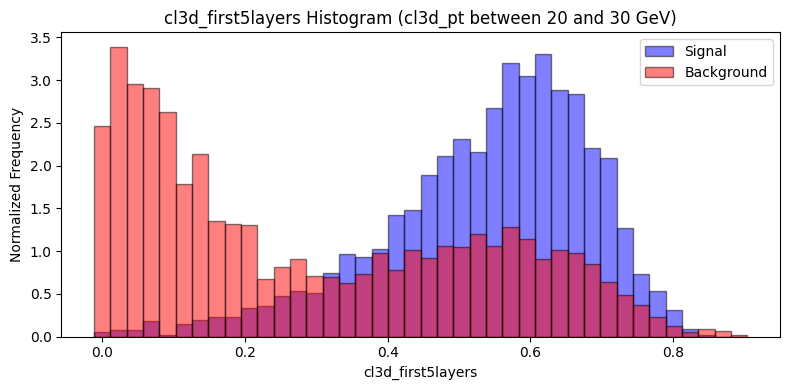

Saved: cl3d_firstHcal1layers_histogram_log_cl3d_pt_20_30.png


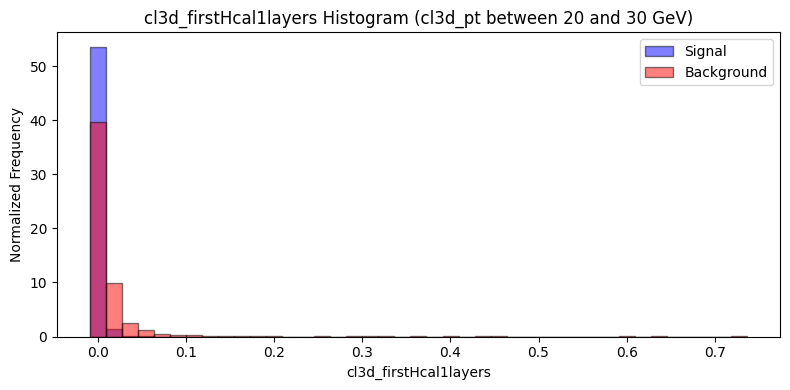

Saved: cl3d_firstHcal3layers_histogram_log_cl3d_pt_20_30.png


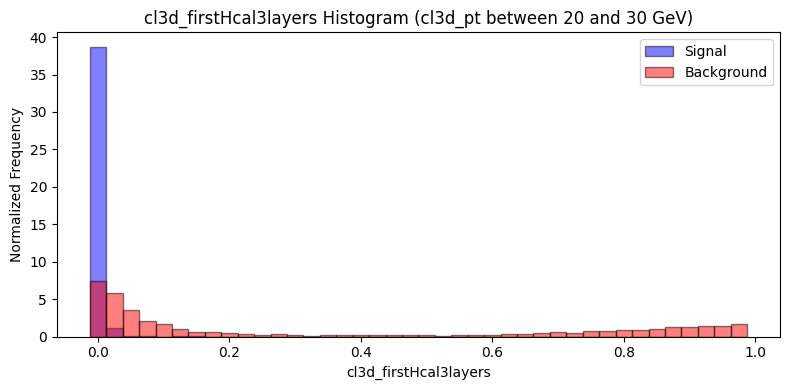

Saved: cl3d_firstHcal5layers_histogram_log_cl3d_pt_20_30.png


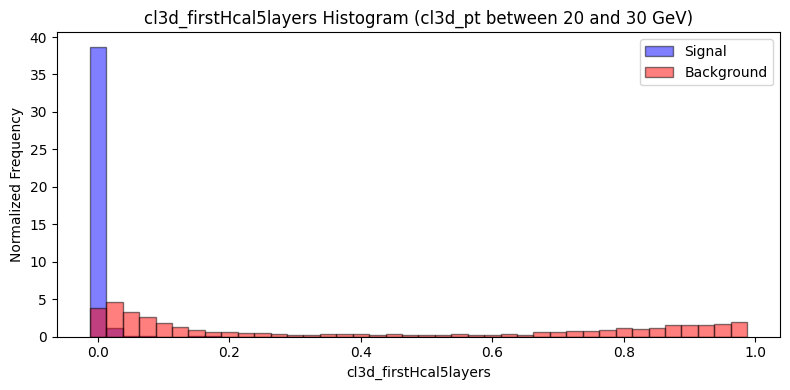

Saved: cl3d_last1layers_histogram_log_cl3d_pt_20_30.png


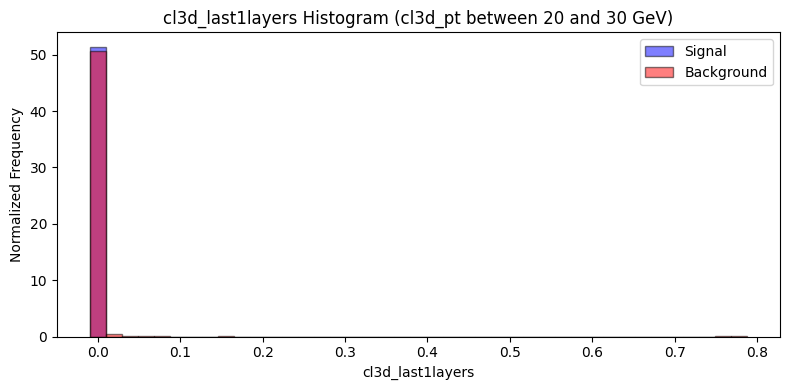

Saved: cl3d_last3layers_histogram_log_cl3d_pt_20_30.png


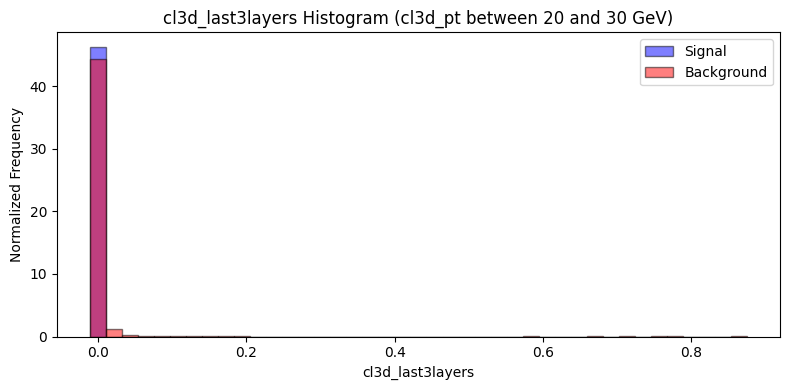

Saved: cl3d_last5layers_histogram_log_cl3d_pt_20_30.png


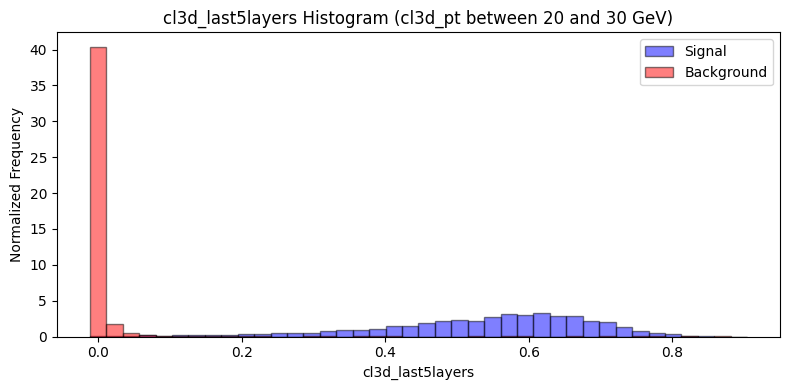

In [36]:
# Call the function with your filtered DataFrame and variables
plot_histograms(df_signal_final_filtered, bg_df_filtered, variables_to_plot, cl3d_pt_range=(20, 30))

In [37]:
# Get the common columns between signal and background DataFrames
common_columns = df_signal_final_filtered.columns.intersection(bg_df_filtered.columns)

# Keep only the common columns in both DataFrames
df_signal_filtered_final = df_signal_final_filtered[common_columns]
df_bg_filtered_final = bg_df_filtered[common_columns]

# Display the columns to verify
print("Signal DataFrame columns after filtering:", df_signal_filtered_final.columns)
print("Background DataFrame columns after filtering:", df_bg_filtered_final.columns)

Signal DataFrame columns after filtering: Index(['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'genpart_exphi',
       'genpart_exeta', 'cl3d_n', 'cl3d_id', 'cl3d_pt', 'cl3d_energy',
       'cl3d_eta', 'cl3d_phi', 'cl3d_clusters_n', 'cl3d_clusters_id',
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe',
       'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_first1layers', 'cl3d_first3layers',
       'cl3d_first5layers', 'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_emax5layers', 'cl3d_eot', 'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm',
       'cl3d_ntc67', 

In [38]:
# Add labels to signal (1) and background (0) DataFrames
df_signal_filtered_final['label'] = 1
df_bg_filtered_final['label'] = 0

# Select only the relevant cl3d variables and the label for training
cl3d_variables = [col for col in df_signal_filtered_final.columns if col.startswith('cl3d')]

# Merge signal and background datasets
df_combined = pd.concat([df_signal_filtered_final[cl3d_variables + ['label']],
                         df_bg_filtered_final[cl3d_variables + ['label']]],
                         ignore_index=True)

# Separate features and target
X = df_combined[cl3d_variables]
y = df_combined['label']

/tmp/ipykernel_67755/2757330137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_filtered_final['label'] = 1


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Define the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)

# Train the model
model.fit(X_train, y_train)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
# Predictions and performance metrics
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 1.00
ROC AUC: 1.00


In [47]:
pt_bins = [20, 22, 24, 26, 28, 30]
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)

# Columns for training
columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

# Filter data for training, ensuring we are working only with the relevant pT range
filtered_data = df_combined[df_combined['cl3d_pt'].between(20, 30)][columns_for_training + ['label', 'pt_bin']]

Training for pT bin: 20 - 22


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getli

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Saved: 20_22_importance_score.png


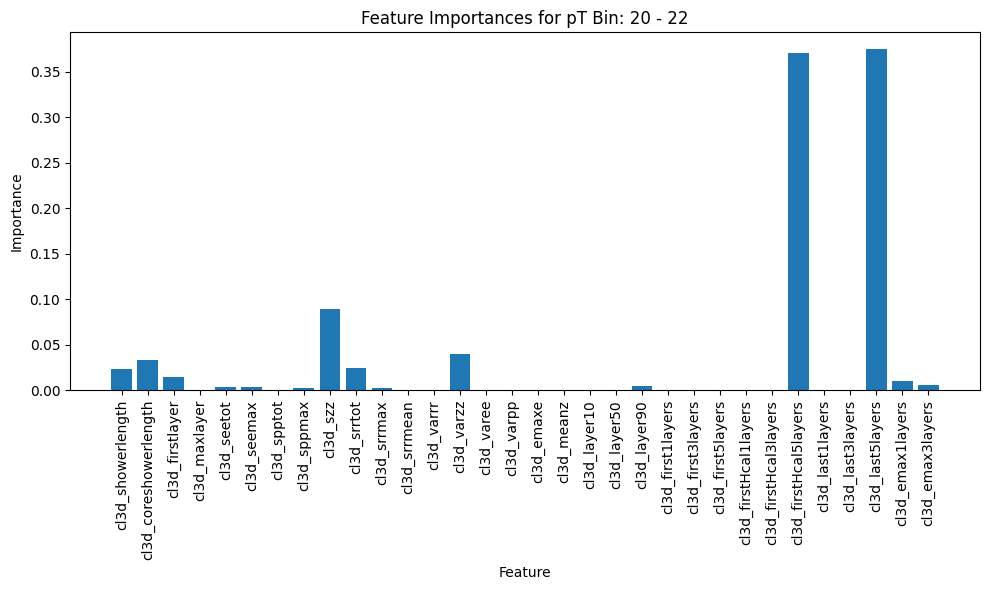

Saved: ROC_20_22.png


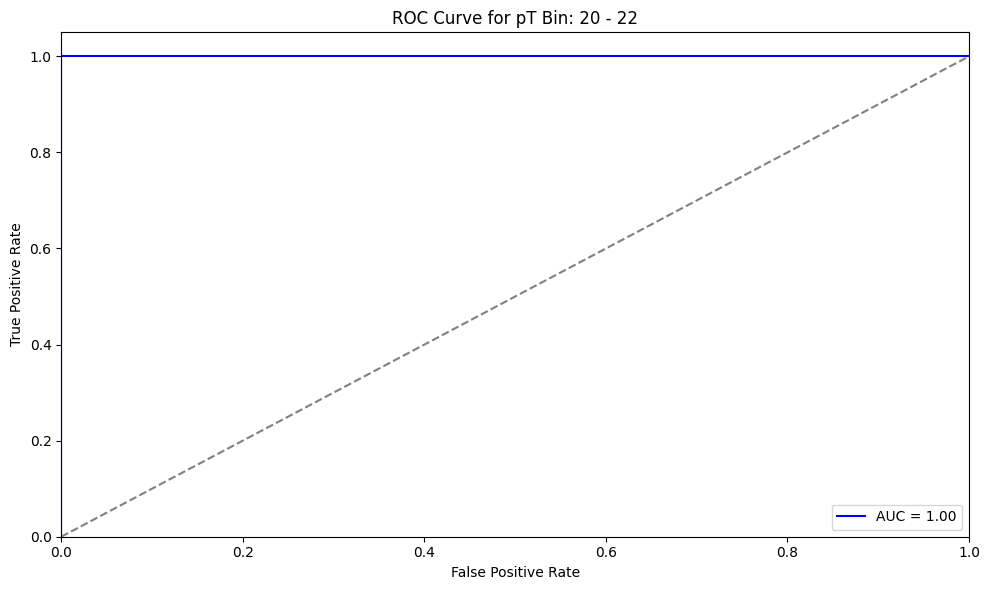

Training for pT bin: 22 - 24
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Saved: 22_24_importance_score.png


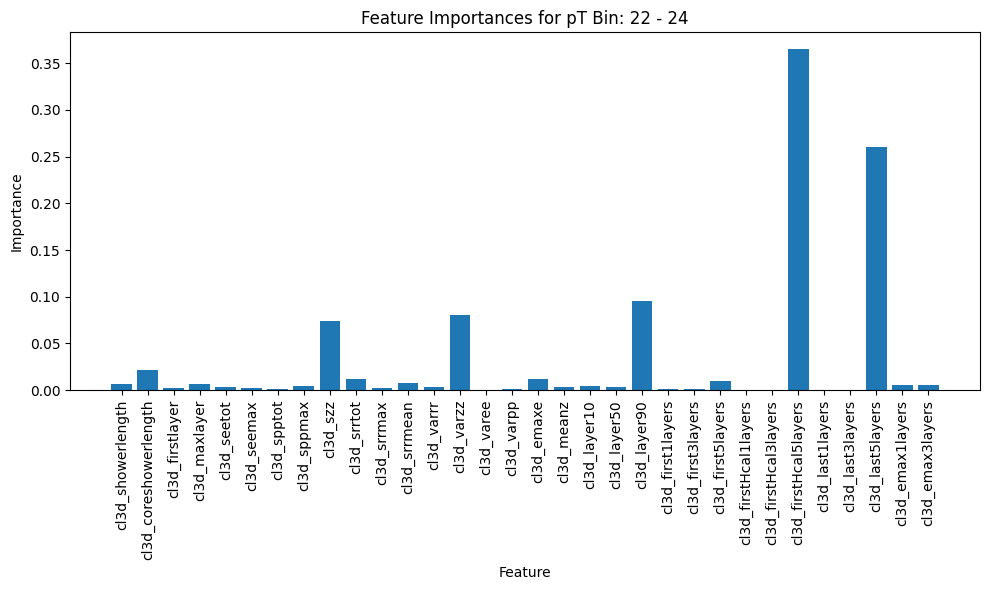

Saved: ROC_22_24.png


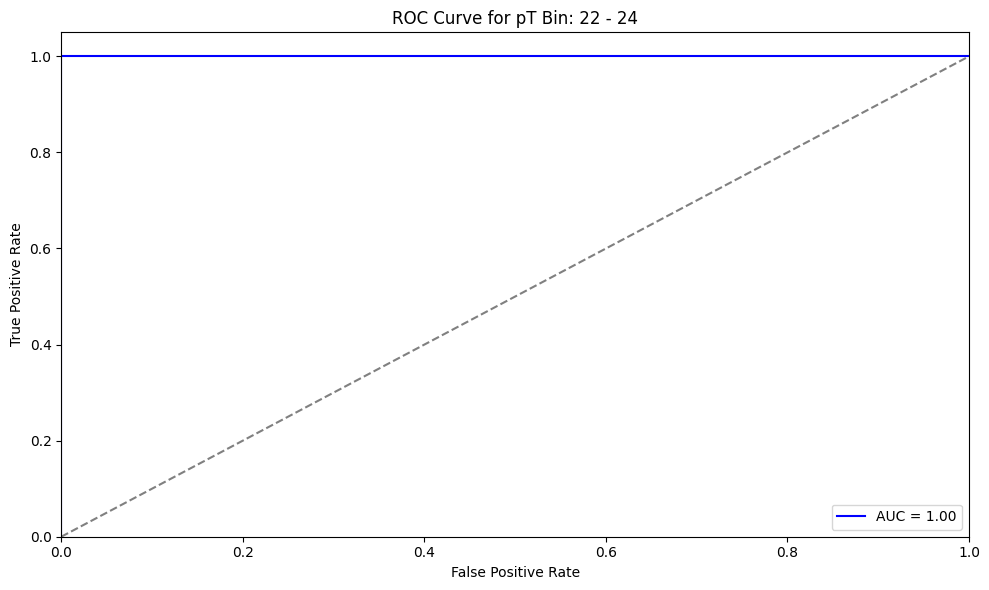

Training for pT bin: 24 - 26
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Saved: 24_26_importance_score.png


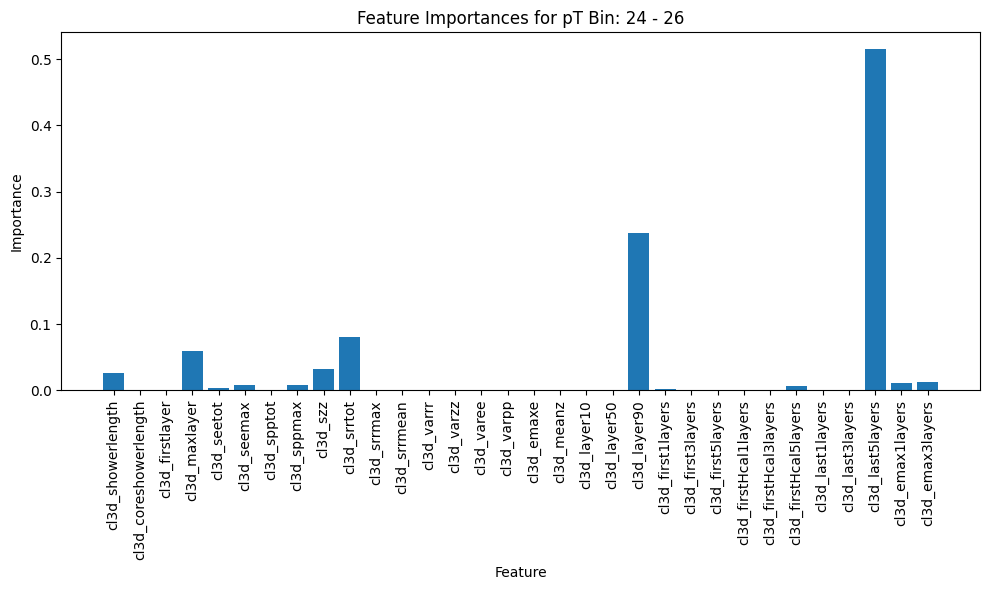

Saved: ROC_24_26.png


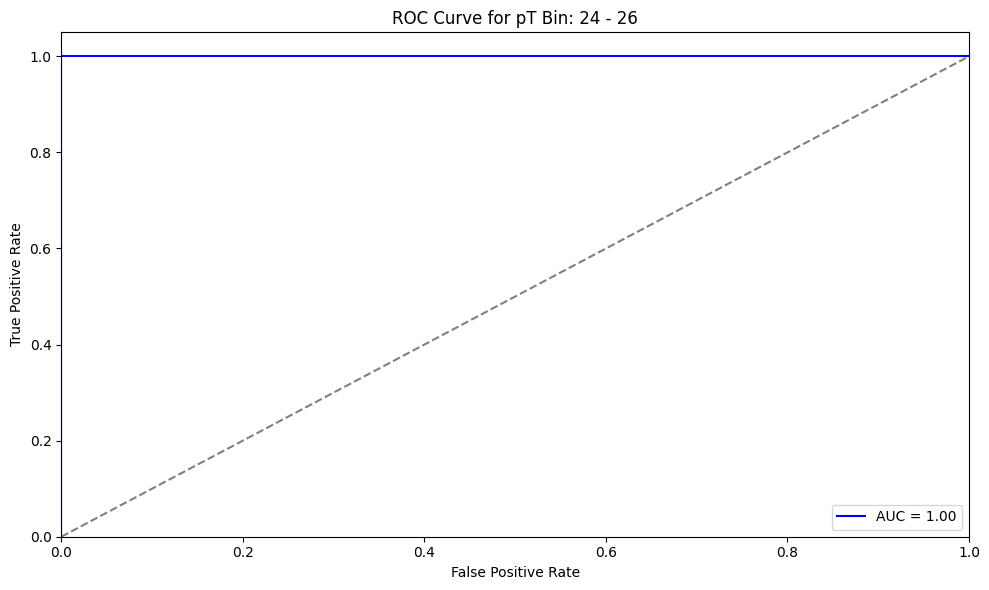

Training for pT bin: 26 - 28
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Saved: 26_28_importance_score.png


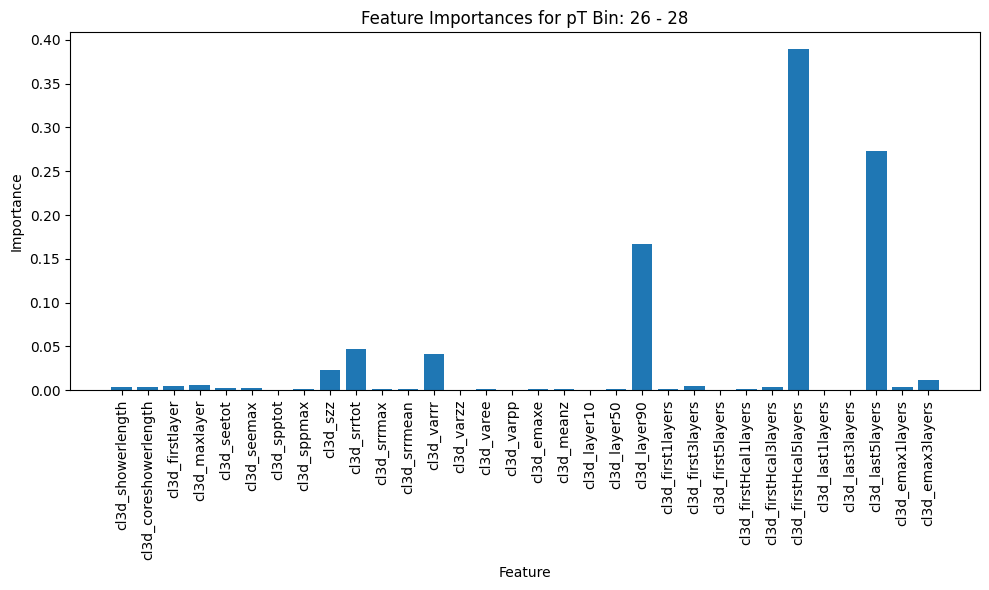

Saved: ROC_26_28.png


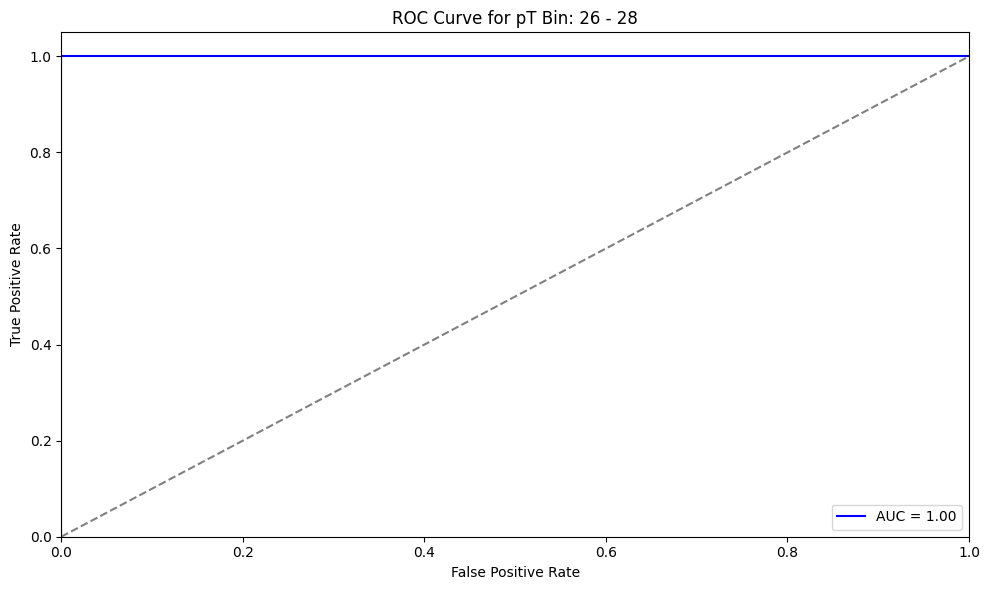

Training for pT bin: 28 - 30
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Saved: 28_30_importance_score.png


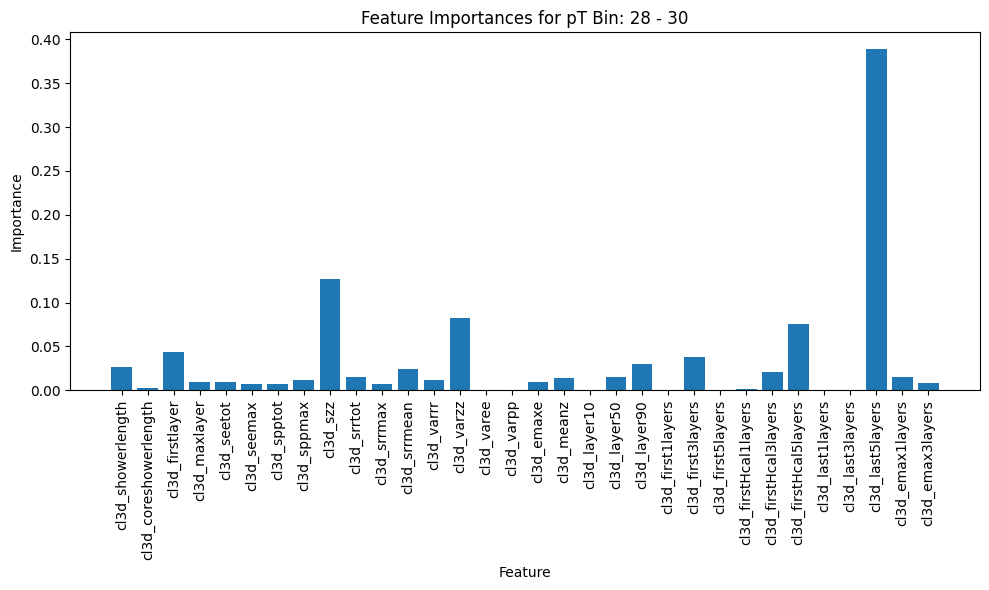

Saved: ROC_28_30.png


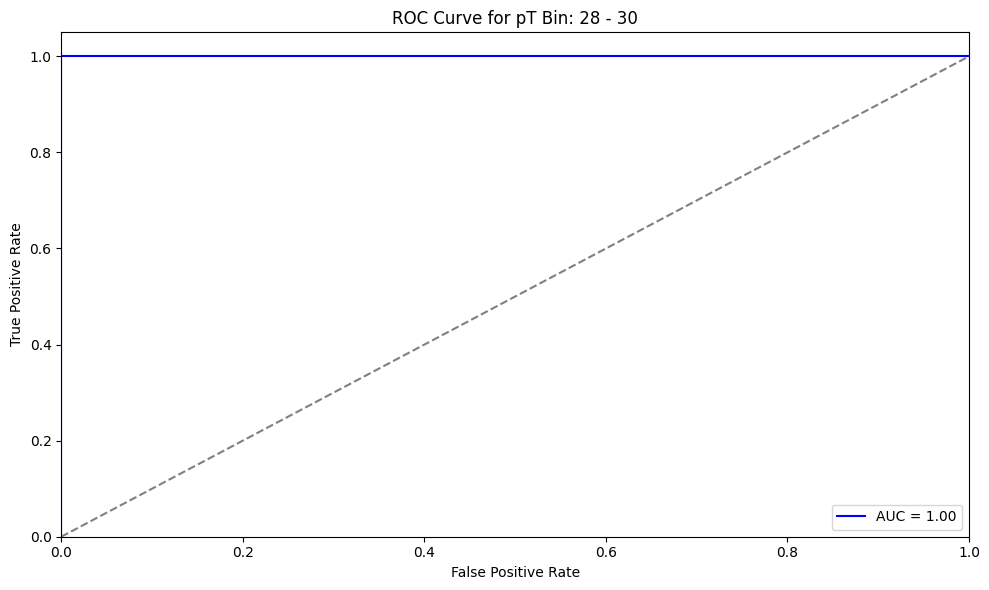

In [51]:
# Hyperparameter grid for optimization
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Function to train and optimize XGBoost model
def optimize_and_plot(filtered_data, pt_bins, columns_for_training, param_grid):
    feature_importance_by_bin = {}
    roc_auc_scores = {}

    for pt_bin in range(len(pt_bins) - 1):  # Loop through bins
        print(f"Training for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
        
        # Filter data for the current bin
        bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
        X = bin_data[columns_for_training]
        y = bin_data['label']
        
        # Check class balance
        class_counts = y.value_counts()
        if len(class_counts) < 2:  # Less than two classes present
            print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
            continue
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Initialize XGBoost classifier
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model from grid search
        best_model = grid_search.best_estimator_
        print(f"Best hyperparameters: {grid_search.best_params_}")
        
        # Save feature importances
        feature_importances = best_model.feature_importances_
        feature_importance_by_bin[pt_bin] = feature_importances
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(columns_for_training, feature_importances)
        plt.xticks(rotation=90)
        plt.title(f"Feature Importances for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.tight_layout()
        filename = f"{pt_bins[pt_bin]}_{pt_bins[pt_bin + 1]}_importance_score.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")    
        plt.show()

        # Calculate ROC curve and AUC for the best model
        y_pred_prob = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[pt_bin] = roc_auc
        
        # Plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        filename = f"ROC_{pt_bins[pt_bin]}_{pt_bins[pt_bin + 1]}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()

    return feature_importance_by_bin, roc_auc_scores

# Run the optimization and plotting function
feature_importance_by_bin, roc_auc_scores = optimize_and_plot(filtered_data, pt_bins, columns_for_training, param_grid)
